In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit
import scienceplots
plt.style.use(['science'])
plt.rcParams.update({'font.size': 20,'font.weight':'bold'})

In [2]:
# @njit
def gillespie(k,x0,T,N,tres):
    """
    gillespie Simulation of the Gillespie's algorithm

    Parameters
    ----------
    k : array(NxN)
        Transition rate matrix.
    x0 : int
        initial value of the jump process.[labelled from 0 to N-1]
    T: float
        total time of simulation.
    N: int
        number of states.
    tres: float
        time resolution for output
    """
    t = 0
    x = int(x0)
    k = np.array(k)
    tr = [[x,t]]
    
    states = np.arange(N)
    
    # check if the rate matrix is valid, with column sums zero.
    col_sums = np.sum(k, axis=0)
    
    # within zero tolerance, need to rectify this.    
    if not np.allclose(col_sums, 0):
        raise ValueError("Invalid rate matrix: column sums must be zero.")
    
    
    escape_rates = -np.diag(k)
    
    while t < T:
        u = np.random.uniform(0,1)
        dt = np.round(-np.log(u)/escape_rates[x], int(-np.log10(tres)))
        # print(dt)
        t += dt
        if t >= T:
            tr.append([x,T])
            break
        krates = k[:,x].copy()
        krates[x] = 0
        krates = krates/escape_rates[x]
        x2 = np.random.choice(states, p=krates)
        tr.append([x2,t])
        x = int(x2)
    tr = np.array(tr)
    return tr
    

In [3]:
#simulating the evolution of the probability distribution
@njit
def prob_evolution(k,p0,T,N,dt):
    """
    prob_evolution Simulating the evolution of probability distribution over time.

    Parameters
    ----------
    k : array(NxN)
        Transition rate matrix.
    p0 : array(N)
        initial probability distribution.
    T: float
        total time of simulation.
    N: int
        number of states.
    dt: float
        time step for simulation.
    """
        # check if the rate matrix is valid, with column sums zero.
    col_sums = np.sum(k, axis=0)
    
    # within zero tolerance, need to rectify this.    
    if not np.allclose(col_sums, 0):
        raise ValueError("Invalid rate matrix: column sums must be zero.")
    
    num_steps = int(T/dt)+1
    p = np.zeros((num_steps,N))
    p[0,:] = p0
    for i in range(1,num_steps):
        dp = np.dot(k, p[i-1,:])
        p[i,:] = p[i-1,:] + dp*dt
        # print(sum(p[i,:]))
        # if not np.allclose(sum(p[i,:]), 1.0, atol=1e-7):
            # print("Warning: Probability distribution not normalized at step ", i)
    return p

In [4]:
@njit
def create_trajectory(x,tres):
    T = x[-1,1]
    num = int(T/tres)+1
    xdis = np.zeros(num)
    for i in x:
        idx = int(i[1]/tres)
        xdis[idx:] = i[0]
    return xdis
    

In [5]:
@njit
def stoch_entropy_evolution(xdis,p,):
    """
    stoch_entropy_evolution Simulating the evolution of probability distribution over time.

    Parameters
    ----------
    k : array(NxN)
        Transition rate matrix.
    p : array(N)
        probability distribution.
    T: float
        total time of simulation.
    N: int
        number of states.
    dt: float
        time step for simulation.
    tres: float
        time resolution for trajectory creation.
    """
    # xdis = np.array(x)
    
    stoch_entropy = np.zeros(len(xdis))
    for i in range(len(xdis)):
        state = int(xdis[i])
        ps = p[i,state]
        if ps > 0:
            stoch_entropy[i] = -np.log(ps)
        else:
            stoch_entropy[i] = 0.0
    return stoch_entropy

In [6]:
def prob_current(k,p):
    N = len(p)
    J = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                J[i,j] = k[i,j]*p[j] - k[j,i]*p[i]
    return J

In [7]:
@njit
def tot_entropy_production(xdis, stoch_ent,k):
    """
    tot_entropy_production Simulating the total entropy production along a trajectory.

    Parameters
    ----------
    xdis : array
        trajectory of the jump process.
    p : array(N)
        probability distribution.
    N: int
        number of states.
    stoch_ent: array
        stochastic entropy along the trajectory.
    k : array(NxN)
        Transition rate matrix.
    """
    tot_entropy = np.zeros(len(xdis))
    for i in range(1,len(xdis)):
        # System entropy change
        delta_syst = stoch_ent[i] - stoch_ent[i-1]
        # Medium entropy change
        state_from = int(xdis[i-1])
        state_to = int(xdis[i])
        if state_from != state_to:
            delta_med = np.log((k[state_to,state_from])/(k[state_from,state_to]))
        else:
            delta_med = 0.0
        tot_entropy[i] = tot_entropy[i-1] + delta_syst + delta_med
        
   
    return tot_entropy

In [8]:
# @njit
def total_entropy_production(x,stoch_ent,k):
    """
    total_entropy_production Simulating the total entropy production along a trajectory.

    Parameters
    ----------
    xdis : array
        trajectory of the jump process.
    stoch_ent: array
        stochastic entropy along the trajectory.
    k : array(NxN)
        Transition rate matrix.
    """
    total_entropy = stoch_ent[-1] - stoch_ent[0]
    for i in range(1,tr.shape[0]):
        total_entropy += np.log(k[int(x[i,0]),int(x[i-1,0])]/k[int(x[i-1,0]),int(x[i,0])])
        
        
        
   
    return total_entropy

In [9]:
@njit
def central_difference(f, dt):
    """
    central_difference Compute the central difference approximation of the derivative of a function.

    Parameters
    ----------
    f : array
        function values at discrete points.
    dt: float
        time step between discrete points.
    """
    n = len(f)
    df = np.zeros(n)
    for i in range(1, n-1):
        df[i] = (f[i+1] - f[i-1]) / (2*dt)
    # Forward difference for the first point
    df[0] = (f[1] - f[0]) / dt
    # Backward difference for the last point
    df[n-1] = (f[n-1] - f[n-2]) / dt
    return df

In [10]:
def linfit(x, a, b):
    return a * x + b

In [21]:

N = 4
states = np.arange(N)
T = 1

t_e = 10

delta = 1

T_RES = 1e-5

P = 1


In [22]:

k10 = np.round(np.exp(delta/(2*T)), int(-np.log10(T_RES)))
k01 = np.round(np.exp(-delta/(2*T)), int(-np.log10(T_RES)))


k = np.ones((N,N))
# k[0,1] = k01

k[1,0] = P


escape_rates = np.sum(k-np.diag(np.diag(k)), axis=0)
k = k - np.diag(np.diag(k)) + np.diag(-escape_rates)
print(k)

[[-3.  1.  1.  1.]
 [ 1. -3.  1.  1.]
 [ 1.  1. -3.  1.]
 [ 1.  1.  1. -3.]]


In [23]:
p0 = 0.0001*np.ones(N)
p0[0] = 1.0
p0 = p0/np.sum(p0)

In [24]:
%%time
# t_e = 0.11
# p0 = 0.0001*np.ones(N)
# p0[1] = 1.0
# p0 = p0/np.sum(p0)
tr = gillespie(k,1,t_e,N,T_RES)
pr_evo = prob_evolution(k,p0,t_e,N,T_RES)
xdis = create_trajectory(tr,T_RES)

sent = stoch_entropy_evolution(xdis,pr_evo)


# avg_ent = avg_entropy_production(xdis,pr_evo,N,sent)
# # total_entropy_production(tr,sent,k)
# # len(xdis), pr_evo.shape


CPU times: user 315 ms, sys: 2 ms, total: 317 ms
Wall time: 318 ms


In [25]:
times = np.linspace(0,t_e, int(t_e/T_RES)+1)


In [26]:
%%time
avg_tot_ent = np.zeros(len(xdis))

RUNS = 2000
# ents = np.zeros((RUNS, len(xdis)))
for i in range(RUNS):
    print(i)
    traj = gillespie(k,0,t_e,N,T_RES).copy()
    xdiscrete = create_trajectory(traj.copy(),T_RES).copy()
    stochent = stoch_entropy_evolution(xdiscrete.copy(),pr_evo).copy()
    avg_tot_ent += tot_entropy_production(xdiscrete,stochent,k).copy()/RUNS
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
truntime = 50
trucated_time = (truntime/t_e)/T_RES
fit_times = times[int(trucated_time):]
fit_avg_tot_ent = avg_tot_ent[int(trucated_time):]
popt, pcov = curve_fit(linfit, fit_times, fit_avg_tot_ent)
slope = popt[0]
intercept = popt[1]
perr = np.sqrt(np.diag(pcov))
analytical_entropy_production_rate = (P-1)*np.log(P)/(2*P+6)
print("Slope:", slope)
print("Error in slope:", perr[0])
print("Intercept:", intercept)
print("Analytical Entropy Production Rate:", analytical_entropy_production_rate)
    

Slope: 1.854637578697216e-11
Error in slope: 5.256493776699859e-16
Intercept: 1.3859944059721543
Analytical Entropy Production Rate: 0.0


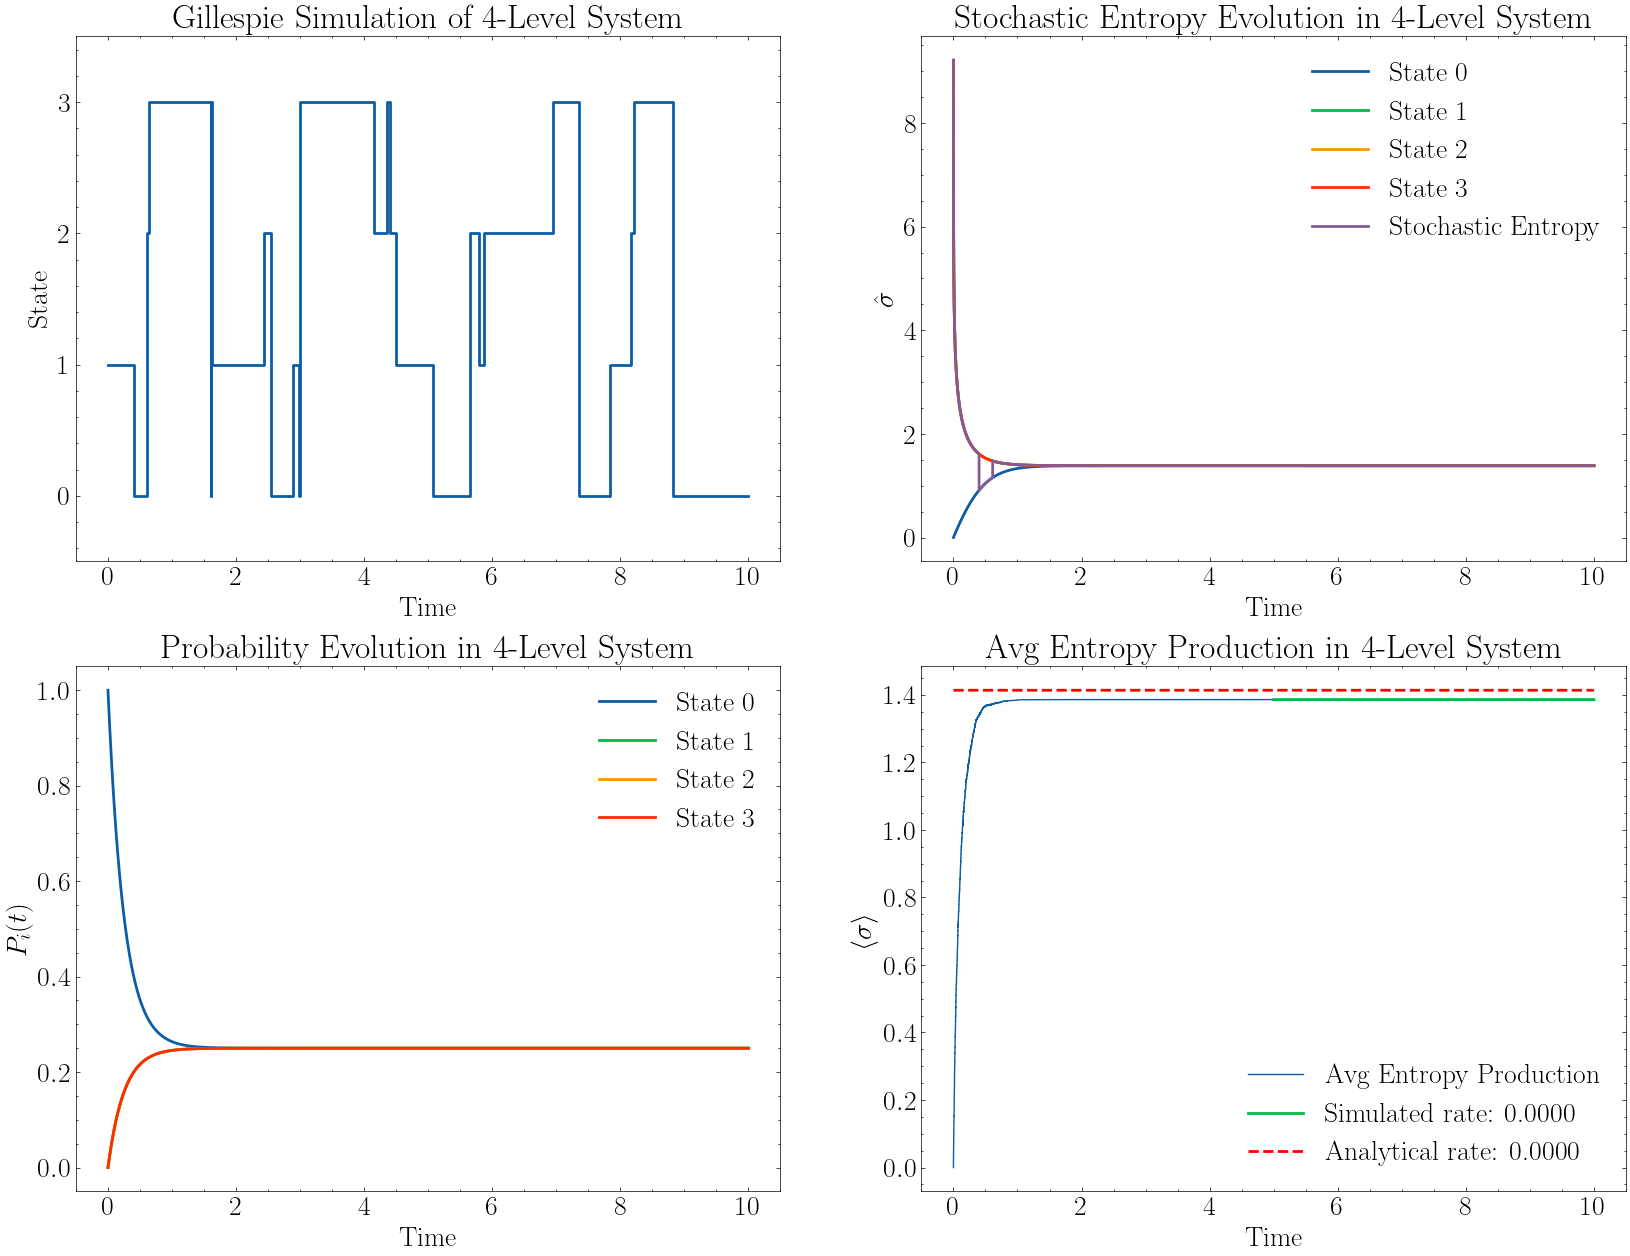

In [29]:
fig,axes = plt.subplots(2,2,figsize=(20,15))

ax = axes[0,0]
ax.step(tr[:,1],tr[:,0],where='post', lw=2)
ax.set_ylim(-0.5,N-0.5)
ax.set_yticks(states)
ax.set_yticklabels([str(i) for i in states])
ax.set_xlabel('Time')
ax.set_ylabel('State')
ax.set_title(f'Gillespie Simulation of {N}-Level System')

ax = axes[1,0]
for i in range(N):
    ax.plot(times, pr_evo[:,i], label='State '+str(i), lw=2)
ax.set_xlabel('Time')
ax.set_ylabel(r'$P_i(t)$')
ax.set_title(f'Probability Evolution in {N}-Level System')
ax.legend()

ax = axes[0,1]
for i in range(N):
    ax.plot(times, -np.log(pr_evo[:,i]), label='State '+str(i), lw =2)
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.set_title(f'log Probability Evolution in {N}-Level System')
ax.plot(times, sent, label='Stochastic Entropy', lw=2)
ax.set_xlabel('Time')
ax.set_ylabel(r'$\hat{\sigma}$')# avg_ents = np.zeros(len(xdis))

ax.set_title(f'Stochastic Entropy Evolution in {N}-Level System')
ax.legend()

ax = axes[1,1]
# ax.plot(np.linspace(0,t_e, int(t_e/T_RES)+1), avg_ent, label='Avg Entropy Production')
ax.plot(times, avg_tot_ent, label='Avg Entropy Production')
ax.plot(fit_times, linfit(fit_times,*popt), label=f'Simulated  rate: {slope:.4f}', lw=2)
ax.plot(times, linfit(times,analytical_entropy_production_rate, 1.02*intercept), label=f'Analytical rate: {analytical_entropy_production_rate:.4f}',color='red',ls='--',lw=2)
ax.set_xlabel('Time')
ax.set_ylabel(r'$\langle \sigma \rangle$')
ax.set_title(f'Avg Entropy Production in {N}-Level System')
ax.legend(loc="lower right")

fig.savefig(f'images/{N}_level_system_analysis_eq_latex.png')

In [81]:

avg_tot_ent = np.zeros(len(xdis))

RUNS = 1000
for i in range(RUNS):
    print(i)
    trj = gillespie(k,0,t_e,N,T_RES).copy()
    xdisc = create_trajectory(trj,T_RES).copy()
    st_ent = stoch_entropy_evolution(xdisc,pr_evo).copy()
    avg_tot_ent += tot_entropy_production(xdisc,st_ent,k).copy()/RUNS

# total_entropy_pro = tot_entropy_production(

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
(1-P)/(3*P+6)

-0.3235294117647059

In [23]:
def analyticalentropy(p):
    return (
        0.5 * ((4*p)/(3+p) - (2*(1+p))/(3+p)) * np.log((2*p)/(1+p))
        + 0.5 * (-(4*p)/(3+p) + (2*(1+p))/(3+p)) * np.log((1+p)/(2*p))
        + (-1 + 4/(3+p)) * np.log(4/(3+p))
        + (-1 + (2*(1+p))/(3+p)) * np.log((2*(1+p))/(3+p))
        + (1 - 4/(3+p)) * np.log((3+p)/4)
        + (1 - (2*(1+p))/(3+p)) * np.log((3+p)/(2*(1+p)))
    )


In [34]:
analytical_entropy_production_rate=analyticalentropy(P)
analytical_entropy_production_rate

np.float64(0.7324081924454064)

In [ ]:
P =5
(P-1)*np.log(P)/(3*P+6)(P-1)*np.log(P)/(3*P+6)

np.float64(0.3065596023684001)

In [36]:
#numerical eigenvectors and eigenvalues of the rate matrix
eigenvalues, eigenvectors = np.linalg.eig(np.eye(N)+k)
eigenvectors[:,0] = eigenvectors[:,0]/np.sum(eigenvectors[:,0])
print("Eigenvalues of the rate matrix:")
print(eigenvalues)

print("Eigenvectors of the rate matrix:")  
print(eigenvectors[:,0])

print("Steady state distribution:")
print(np.sum(eigenvectors[:,0]))
print(pr_evo[-1,:])






Eigenvalues of the rate matrix:
[ 1. -5. -3. -3.]
Eigenvectors of the rate matrix:
[0.16666667 0.33333333 0.25       0.25      ]
Steady state distribution:
1.0
[0.16666667 0.33333333 0.25       0.25      ]


In [35]:
ppp = [3/(P+2),(2*P+1)/(P+2),1]
ppp = np.array(ppp)/np.sum(ppp)
print("Analytical steady state distribution:")
print(ppp)

Analytical steady state distribution:
[0.25       0.41666667 0.33333333]


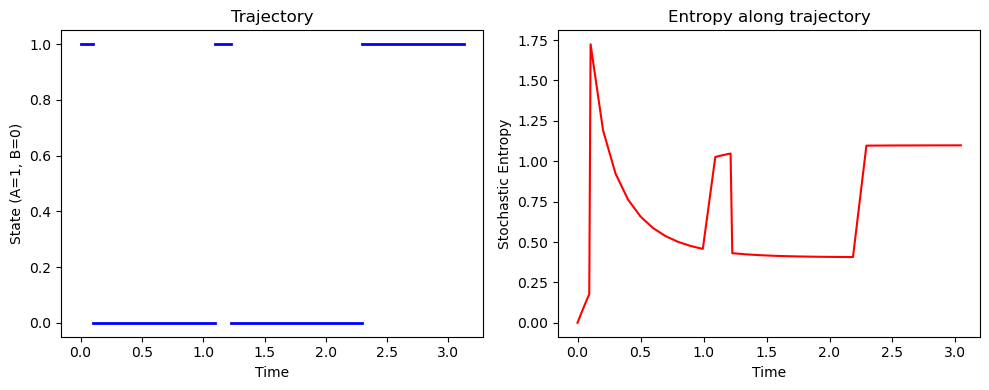

array([[ 0.     ,  0.     ],
       [ 3.     ,  0.24853],
       [ 0.     ,  0.42685],
       [ 3.     ,  0.45319],
       [ 2.     ,  1.33181],
       [ 3.     ,  1.89537],
       [ 1.     ,  1.9516 ],
       [ 0.     ,  3.87392],
       [ 2.     ,  4.02985],
       [ 0.     ,  4.62378],
       [ 3.     ,  5.57948],
       [ 1.     ,  5.87914],
       [ 2.     ,  6.11181],
       [ 3.     ,  6.59423],
       [ 0.     ,  6.69234],
       [ 2.     ,  6.9856 ],
       [ 1.     ,  7.68522],
       [ 2.     ,  8.24856],
       [ 0.     ,  8.81467],
       [ 2.     ,  8.94436],
       [ 1.     ,  9.24226],
       [ 3.     ,  9.31907],
       [ 2.     ,  9.78098],
       [ 1.     ,  9.88988],
       [ 1.     , 10.     ]])

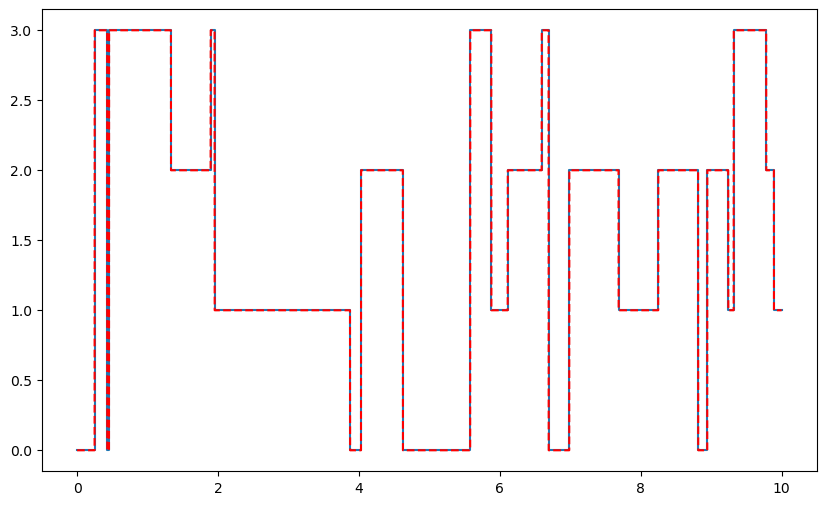

In [ ]:
plt.figure(figsize=(10,6))
plt.step(lol[:,1], lol[:,0], where='post')
plt.plot(np.linspace(0,t_e, int(t_e/T_RES)+1), lold, 'r--')


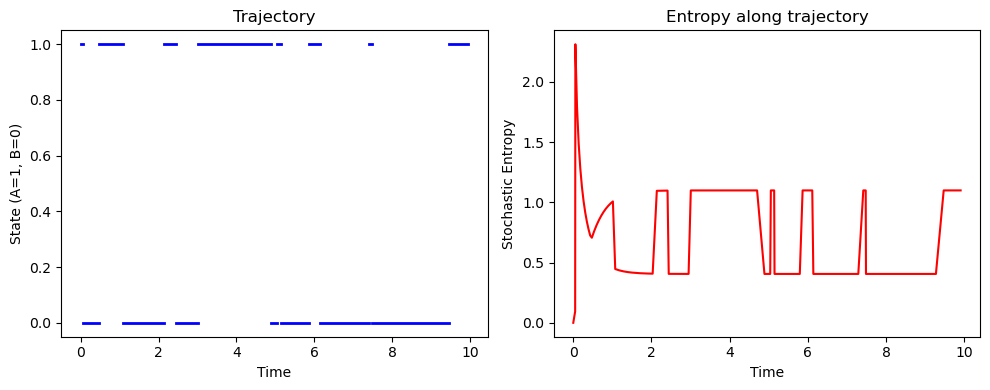